## 🟢 Step 1: Data Understanding & Preprocessing
📌 Objective

The first step in building a Content Moderation System is to understand the dataset and prepare the raw text for further analysis.
This ensures that the machine learning models and rule-based filters work on clean and consistent data.

In [1]:
import re
import string 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
import joblib


In [2]:
df_train=pd.read_csv(r"C:\Users\MF'\Downloads\AI_Camp_Final Project\data\train.csv\train.csv")

In [3]:
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df_train.shape

(159571, 8)

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [6]:
df_train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
def clean_text(text):
    text = str(text).lower()                        
    text = re.sub(r'http\S+|www\S+', '', text)      
    text = re.sub(r'@\w+|#\w+', '', text)           
    text = text.translate(str.maketrans('', '', string.punctuation)) 
    text = re.sub(r'\d+', '', text)         
    text = re.sub(r'\s+', ' ', text).strip()       
    return text

In [8]:
X_raw = df_train['comment_text']
y = df_train[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]


In [9]:
X_clean = X_raw.apply(clean_text)


In [ ]:

df_train['text_length'] = X_raw.astype(str).apply(len)
df_train['word_count'] = X_raw.astype(str).apply(lambda x: len(x.split()))
df_train['caps_ratio'] = X_raw.astype(str).apply(lambda x: sum(1 for c in x if c.isupper()) / (len(x)+1))
df_train['special_char_ratio'] = X_raw.astype(str).apply(lambda x: sum(1 for c in x if not c.isalnum() and not c.isspace()) / (len(x)+1))


In [11]:
for i in range(3):
    print("Original:", X_raw.iloc[i])
    print("Cleaned :", X_clean.iloc[i])
    print("---")

Original: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Cleaned : explanation why the edits made under my username hardcore metallica fan were reverted they werent vandalisms just closure on some gas after i voted at new york dolls fac and please dont remove the template from the talk page since im retired now
---
Original: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Cleaned : daww he matches this background colour im seemingly stuck with thanks talk january utc
---
Original: Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual inf

## 🟢 Step 2: Rule-Based Filter

The idea of a Rule-Based Filter is to catch obvious toxic/spam content without machine learning, using simple heuristics:

Keyword blacklist → detect offensive/banned words.

Pattern matching → detect URLs, emails, promotions, repeated characters.

Text style rules → detect excessive capitalization, too many special characters, etc.

This will be combined later with the ML model in the Risk Assessment Engine.

In [12]:

# Example blacklist of offensive words (you can expand this list)
blacklist = ["idiot", "stupid", "hate", "kill", "fool", "bastard"]

def rule_based_filter(text):
    flags = {
        "blacklist": 0,
        "url": 0,
        "email": 0,
        "excessive_caps": 0,
        "char_repetition": 0
    }
    
    # Convert to lowercase for matching
    text_lower = text.lower()
    
    # 1. Blacklist words
    for word in blacklist:
        if word in text_lower:
            flags["blacklist"] = 1
            break
    
    # 2. URL detection
    if re.search(r"http\S+|www\.\S+", text):
        flags["url"] = 1
    
    # 3. Email detection
    if re.search(r"\S+@\S+\.\S+", text):
        flags["email"] = 1
    
    # 4. Excessive capitalization (more than 50% of chars are uppercase)
    if len(text) > 0:
        caps_ratio = sum(1 for c in text if c.isupper()) / len(text)
        if caps_ratio > 0.5:
            flags["excessive_caps"] = 1
    
    # 5. Character repetition (like "loooool" or "!!!!!!!")
    if re.search(r"(.)\1{4,}", text):  # 4 or more repetitions
        flags["char_repetition"] = 1
    
    return flags

In [13]:
# Apply rule-based filter on first 5 comments
sample_comments = df_train['comment_text'].head(5)

for i, comment in enumerate(sample_comments, 1):
    print(f"Comment {i}: {comment[:60]}...")
    print("Flags:", rule_based_filter(comment))
    print("---")

Comment 1: Explanation
Why the edits made under my username Hardcore Me...
Flags: {'blacklist': 0, 'url': 0, 'email': 0, 'excessive_caps': 0, 'char_repetition': 0}
---
Comment 2: D'aww! He matches this background colour I'm seemingly stuck...
Flags: {'blacklist': 0, 'url': 0, 'email': 0, 'excessive_caps': 0, 'char_repetition': 0}
---
Comment 3: Hey man, I'm really not trying to edit war. It's just that t...
Flags: {'blacklist': 0, 'url': 0, 'email': 0, 'excessive_caps': 0, 'char_repetition': 0}
---
Comment 4: "
More
I can't make any real suggestions on improvement - I ...
Flags: {'blacklist': 0, 'url': 0, 'email': 0, 'excessive_caps': 0, 'char_repetition': 0}
---
Comment 5: You, sir, are my hero. Any chance you remember what page tha...
Flags: {'blacklist': 0, 'url': 0, 'email': 0, 'excessive_caps': 0, 'char_repetition': 0}
---


## 🟢 Step 3: Machine Learning Classifier
📌 Objective

After cleaning and preprocessing the text, the next step is to train machine learning models to classify comments into categories:

toxic

severe_toxic

obscene

threat

insult

identity_hate

This is a multi-label classification problem, because each comment can belong to multiple categories at the same time.

## 📂 Approach

Vectorize text → convert cleaned text into numeric format using TF-IDF (Term Frequency–Inverse Document Frequency).

Train classifiers → try multiple ML algorithms:

Logistic Regression

Naive Bayes

Support Vector Machines (SVM)

Random Forest

Evaluate performance → using metrics like accuracy, F1-score, ROC-AUC.

Save models → for integration with the Risk Engine later.

In [14]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(
    X_clean, y, test_size=0.2, random_state=42
)

In [15]:
# TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)


### Logistic Regression for multi-label

In [16]:
from sklearn.multiclass import OneVsRestClassifier

In [17]:
# Logistic Regression for multi-label
# One-vs-Rest Logistic Regression
log_reg = OneVsRestClassifier(LogisticRegression(max_iter=1000))

log_reg.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

In [18]:
# Predictions
y_pred_log = log_reg.predict(X_val_tfidf)

In [19]:
# Evaluation
print("Classification Report:")
print(classification_report(y_val, y_pred_log, target_names=y.columns))


Classification Report:
               precision    recall  f1-score   support

        toxic       0.90      0.61      0.73      3056
 severe_toxic       0.58      0.26      0.36       321
      obscene       0.91      0.63      0.75      1715
       threat       0.65      0.15      0.24        74
       insult       0.83      0.52      0.64      1614
identity_hate       0.74      0.17      0.28       294

    micro avg       0.87      0.56      0.68      7074
    macro avg       0.77      0.39      0.50      7074
 weighted avg       0.86      0.56      0.67      7074
  samples avg       0.06      0.05      0.05      7074



c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

In [20]:
# Save model + vectorizer
joblib.dump(log_reg, "log_reg_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")

['tfidf_vectorizer.pkl']

### Naive Bayes 

In [21]:
from sklearn.naive_bayes import MultinomialNB

In [22]:
# Naive Bayes (One-vs-Rest)
# ------------------------------
nb_clf = OneVsRestClassifier(MultinomialNB())
nb_clf.fit(X_train_tfidf, y_train)

OneVsRestClassifier(estimator=MultinomialNB())

In [23]:
y_pred_nb = nb_clf.predict(X_val_tfidf)

print("🔹 Naive Bayes Report")
print(classification_report(y_val, y_pred_nb, target_names=y.columns))


🔹 Naive Bayes Report
               precision    recall  f1-score   support

        toxic       0.92      0.52      0.66      3056
 severe_toxic       0.61      0.17      0.26       321
      obscene       0.91      0.53      0.67      1715
       threat       0.00      0.00      0.00        74
       insult       0.81      0.44      0.57      1614
identity_hate       0.66      0.06      0.12       294

    micro avg       0.88      0.46      0.61      7074
    macro avg       0.65      0.29      0.38      7074
 weighted avg       0.86      0.46      0.60      7074
  samples avg       0.05      0.04      0.04      7074



c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{met

In [24]:
from sklearn.metrics import f1_score, accuracy_score

In [25]:
# Evaluate Logistic Regression
f1_log = f1_score(y_val, y_pred_log, average="micro")
acc_log = accuracy_score(y_val, y_pred_log)

# Evaluate Naive Bayes
f1_nb = f1_score(y_val, y_pred_nb, average="micro")
acc_nb = accuracy_score(y_val, y_pred_nb)

print("🔹 Logistic Regression - F1 (micro):", f1_log, "Accuracy:", acc_log)
print("🔹 Naive Bayes - F1 (micro):", f1_nb, "Accuracy:", acc_nb)

🔹 Logistic Regression - F1 (micro): 0.6807446991897949 Accuracy: 0.9192856023813254
🔹 Naive Bayes - F1 (micro): 0.6077030162412993 Accuracy: 0.9128309572301425


###  Visualization

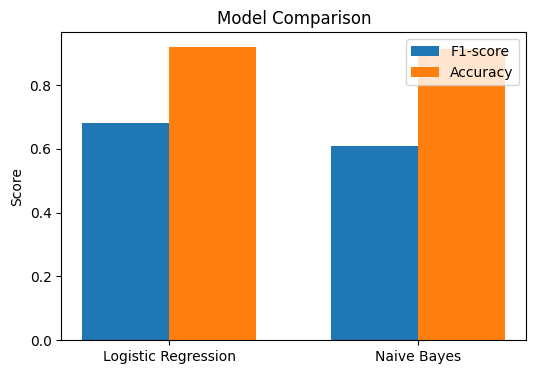

In [26]:

models = ["Logistic Regression", "Naive Bayes"]
f1_scores = [f1_log, f1_nb]
acc_scores = [acc_log, acc_nb]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots(figsize=(6,4))
rects1 = ax.bar(x - width/2, f1_scores, width, label="F1-score")
rects2 = ax.bar(x + width/2, acc_scores, width, label="Accuracy")

ax.set_ylabel("Score")
ax.set_title("Model Comparison")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.show()

### Random Forest

In [28]:
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier

svm_clf = OneVsRestClassifier(LinearSVC())
svm_clf.fit(X_train_tfidf, y_train)


OneVsRestClassifier(estimator=LinearSVC())

In [30]:
y_pred_svm = svm_clf.predict(X_val_tfidf)

print("🔹 SVM  Report")
print(classification_report(y_val, y_pred_svm, target_names=y.columns))


🔹 SVM  Report
               precision    recall  f1-score   support

        toxic       0.87      0.66      0.75      3056
 severe_toxic       0.57      0.22      0.32       321
      obscene       0.89      0.68      0.78      1715
       threat       0.57      0.23      0.33        74
       insult       0.80      0.55      0.65      1614
identity_hate       0.69      0.23      0.35       294

    micro avg       0.85      0.60      0.70      7074
    macro avg       0.73      0.43      0.53      7074
 weighted avg       0.84      0.60      0.69      7074
  samples avg       0.06      0.05      0.05      7074



c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

rf = OneVsRestClassifier(
    RandomForestClassifier(
        n_estimators=50,      
        max_depth=20,          
        max_features="sqrt",   
        n_jobs=-1,             
        random_state=42
    )
)

print("🔹 Training Optimized Random Forest...")
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_val_tfidf)

print("✅ Done!")


🔹 Training Optimized Random Forest...
✅ Done!


In [34]:
y_pred_rf = rf.predict(X_val_tfidf)

print("🔹 RF Report")
print(classification_report(y_val, y_pred_rf, target_names=y.columns))


🔹 RF Report
               precision    recall  f1-score   support

        toxic       0.99      0.10      0.18      3056
 severe_toxic       1.00      0.01      0.01       321
      obscene       1.00      0.07      0.14      1715
       threat       0.00      0.00      0.00        74
       insult       0.91      0.04      0.07      1614
identity_hate       0.00      0.00      0.00       294

    micro avg       0.98      0.07      0.13      7074
    macro avg       0.65      0.04      0.07      7074
 weighted avg       0.92      0.07      0.13      7074
  samples avg       0.01      0.00      0.01      7074



c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{met

In [31]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [35]:
# Define Models
# ------------------------------
models = {
    "Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=1000)),
    "Naive Bayes": OneVsRestClassifier(MultinomialNB()),
    "Linear SVM": OneVsRestClassifier(LinearSVC()),
   # "Random Forest": OneVsRestClassifier(RandomForestClassifier(n_estimators=200, random_state=42)),
    "XGBoost": OneVsRestClassifier(
        XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    )
}

In [36]:
# Train & Evaluate
# ------------------------------
results = {}
for name, model in models.items():
    print(f"🔹 Training {name} ...")
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_val_tfidf)
    
    acc = accuracy_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred, average="micro")
    results[name] = {"Accuracy": acc, "F1": f1}
    
    print(f"✅ {name} Results")
    print(classification_report(y_val, y_pred, target_names=y.columns))
    print("-" * 60)

🔹 Training Logistic Regression ...
✅ Logistic Regression Results
               precision    recall  f1-score   support

        toxic       0.90      0.61      0.73      3056
 severe_toxic       0.58      0.26      0.36       321
      obscene       0.91      0.63      0.75      1715
       threat       0.65      0.15      0.24        74
       insult       0.83      0.52      0.64      1614
identity_hate       0.74      0.17      0.28       294

    micro avg       0.87      0.56      0.68      7074
    macro avg       0.77      0.39      0.50      7074
 weighted avg       0.86      0.56      0.67      7074
  samples avg       0.06      0.05      0.05      7074

------------------------------------------------------------
🔹 Training Naive Bayes ...


c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

✅ Naive Bayes Results
               precision    recall  f1-score   support

        toxic       0.92      0.52      0.66      3056
 severe_toxic       0.61      0.17      0.26       321
      obscene       0.91      0.53      0.67      1715
       threat       0.00      0.00      0.00        74
       insult       0.81      0.44      0.57      1614
identity_hate       0.66      0.06      0.12       294

    micro avg       0.88      0.46      0.61      7074
    macro avg       0.65      0.29      0.38      7074
 weighted avg       0.86      0.46      0.60      7074
  samples avg       0.05      0.04      0.04      7074

------------------------------------------------------------
🔹 Training Linear SVM ...


c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{met

✅ Linear SVM Results
               precision    recall  f1-score   support

        toxic       0.87      0.66      0.75      3056
 severe_toxic       0.57      0.22      0.32       321
      obscene       0.89      0.68      0.78      1715
       threat       0.57      0.23      0.33        74
       insult       0.80      0.55      0.65      1614
identity_hate       0.69      0.23      0.35       294

    micro avg       0.85      0.60      0.70      7074
    macro avg       0.73      0.43      0.53      7074
 weighted avg       0.84      0.60      0.69      7074
  samples avg       0.06      0.05      0.05      7074

------------------------------------------------------------
🔹 Training XGBoost ...


c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

✅ XGBoost Results
               precision    recall  f1-score   support

        toxic       0.90      0.58      0.71      3056
 severe_toxic       0.40      0.20      0.26       321
      obscene       0.87      0.70      0.78      1715
       threat       0.38      0.20      0.27        74
       insult       0.76      0.57      0.65      1614
identity_hate       0.57      0.23      0.33       294

    micro avg       0.83      0.57      0.68      7074
    macro avg       0.65      0.41      0.50      7074
 weighted avg       0.82      0.57      0.67      7074
  samples avg       0.05      0.05      0.05      7074

------------------------------------------------------------


c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

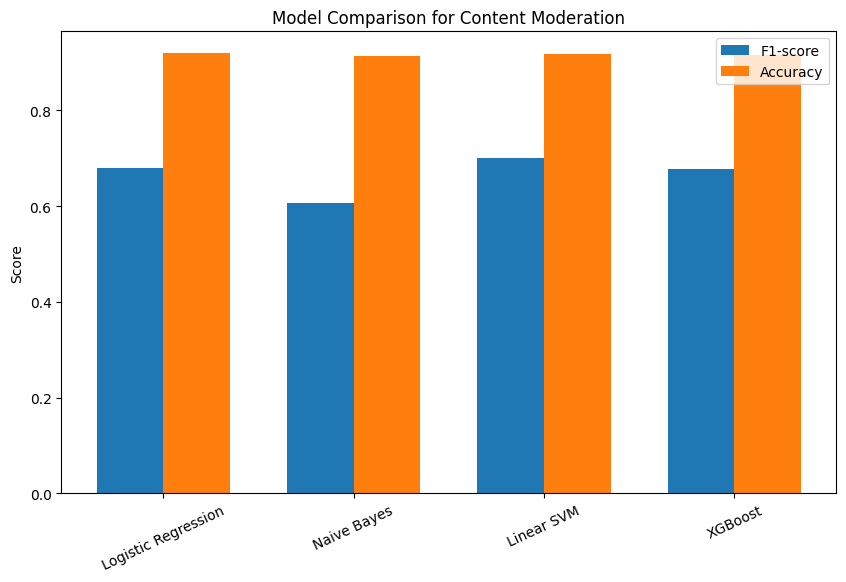

In [37]:
# Visualization
# ------------------------------
names = list(results.keys())
f1_scores = [results[m]["F1"] for m in names]
acc_scores = [results[m]["Accuracy"] for m in names]

x = np.arange(len(names))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, f1_scores, width, label="F1-score")
rects2 = ax.bar(x + width/2, acc_scores, width, label="Accuracy")

ax.set_ylabel("Score")
ax.set_title("Model Comparison for Content Moderation")
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=25)
ax.legend()

plt.show()

### 🟣 Step 4: Risk Assessment Engine
📌 Goal

In real-world content moderation systems (e.g., YouTube, Facebook, OpenAI filters), decisions are not based only on ML predictions.
They combine:

Rule-based filters (offensive keywords, spam patterns, excessive capitalization).

ML predictions (probability that a comment is toxic, spam, safe).

The Risk Assessment Engine merges both to give a final risk score and decision.

### 🛠️ Approach

Rule-based Scoring

Offensive keywords → adds risk

Spam patterns (URLs, mentions, hashtags) → adds risk

Excessive capitalization → adds risk

ML Scoring

Use model prediction probabilities.

Extract the highest probability class.

Weighted Risk Score

Combine ML score + Rule-based score

Example: final_score = 0.6 * ml_score + 0.4 * rule_score

Decision Thresholds

Final Score > 0.75 → 🚨 Harmful (Block)

Final Score > 0.40 → ⚠️ Suspicious (Review)

Else → ✅ Safe

In [38]:
# Rule-based scoring
# ------------------------------
def rule_based_score(text):
    score = 0
    
    # Offensive keywords
    bad_words = ["idiot", "stupid", "hate", "kill"]
    if any(word in text.lower() for word in bad_words):
        score += 0.3
    
    # Spam patterns (URLs, mentions, hashtags)
    if re.search(r"http|www|@\w+|#\w+", text):
        score += 0.2
    
    # Excessive capitalization
    if sum(1 for c in text if c.isupper()) / max(len(text),1) > 0.3:
        score += 0.2
    
    return min(score, 1.0)  # normalize between 0 and 1

In [39]:
# Risk assessment function
# ------------------------------
def risk_assessment(text, model, vectorizer, threshold=0.5):
    # Rule-based risk
    rule_score = rule_based_score(text)
    
    # ML prediction probabilities
    X = vectorizer.transform([text])
    probs = model.predict_proba(X)
    ml_score = np.max(probs)  # highest probability
    
    # Weighted final score
    final_score = 0.6 * ml_score + 0.4 * rule_score
    
    # Decision
    if final_score > 0.75:
        decision = "🚨 Harmful (Block)"
    elif final_score > 0.4:
        decision = "⚠️ Suspicious (Review)"
    else:
        decision = "✅ Safe"
    
    return {
        "text": text,
        "rule_score": round(rule_score, 2),
        "ml_score": round(float(ml_score), 2),
        "final_score": round(float(final_score), 2),
        "decision": decision
    }


In [43]:
# Example usage
# ------------------------------
sample_texts = [
    "I hate you, idiot!",
    "Check my website http://spam.com",
    "HELLO FRIEND",
    "This is a nice comment"
]

for t in sample_texts:
    print(risk_assessment(t, log_reg,vectorizer, threshold=0.5))

{'text': 'I hate you, idiot!', 'rule_score': 0.3, 'ml_score': 1.0, 'final_score': 0.72, 'decision': '⚠️ Suspicious (Review)'}
{'text': 'Check my website http://spam.com', 'rule_score': 0.2, 'ml_score': 0.09, 'final_score': 0.13, 'decision': '✅ Safe'}
{'text': 'HELLO FRIEND', 'rule_score': 0.2, 'ml_score': 0.04, 'final_score': 0.1, 'decision': '✅ Safe'}
{'text': 'This is a nice comment', 'rule_score': 0, 'ml_score': 0.05, 'final_score': 0.03, 'decision': '✅ Safe'}


In [ ]:
import joblib

joblib.dump(log_reg, "log_reg_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [51]:
from sklearn.utils import resample

# Example: oversample threat class
df_threat = df_train[df_train["threat"] == 1]
df_non_threat = df_train[df_train["threat"] == 0]

df_threat_oversampled = resample(df_threat,
                                 replace=True,
                                 n_samples=len(df_non_threat)//5,
                                 random_state=42)

df_balanced = pd.concat([df_non_threat, df_threat_oversampled])


### 🟣 Step 6: Model Evaluation & Comparison
📌 Goal

Show that your system is reliable by evaluating different models.

Metrics to Compare

Accuracy (overall correctness)

Precision (how many predicted toxic are really toxic)

Recall (how many toxic comments you caught)

F1-score (balance between precision & recall)

ROC-AUC (quality of ranking)

### Balance the dataset

In [52]:

# Labels
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

# X = comments, y = multi-label targets
X = df_train["comment_text"]
y = df_train[labels]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fit TF-IDF on training data
tfidf_vectorizer = TfidfVectorizer(max_features=5000, stop_words="english")
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)


In [53]:


y_pred_lr = log_reg.predict(X_test_tfidf)

print("📊 Logistic Regression Report")
print(classification_report(y_test, y_pred_lr, target_names=labels))


📊 Logistic Regression Report
               precision    recall  f1-score   support

        toxic       0.17      0.04      0.06      3056
 severe_toxic       0.00      0.00      0.00       321
      obscene       0.34      0.03      0.06      1715
       threat       0.00      0.00      0.00        74
       insult       0.03      0.00      0.00      1614
identity_hate       0.00      0.00      0.00       294

    micro avg       0.19      0.02      0.04      7074
    macro avg       0.09      0.01      0.02      7074
 weighted avg       0.16      0.02      0.04      7074
  samples avg       0.00      0.00      0.00      7074



c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{met

In [54]:
from sklearn.metrics import classification_report, roc_auc_score

# Logistic Regression evaluation
y_pred_lr = log_reg.predict(X_test_tfidf)
print("📊 Logistic Regression Report")
print(classification_report(y_test, y_pred_lr, target_names=labels))

# SVM evaluation
y_pred_svm = svm_clf.predict(X_test_tfidf)
print("📊 Linear SVM Report")
print(classification_report(y_test, y_pred_svm, target_names=labels))



📊 Logistic Regression Report
               precision    recall  f1-score   support

        toxic       0.17      0.04      0.06      3056
 severe_toxic       0.00      0.00      0.00       321
      obscene       0.34      0.03      0.06      1715
       threat       0.00      0.00      0.00        74
       insult       0.03      0.00      0.00      1614
identity_hate       0.00      0.00      0.00       294

    micro avg       0.19      0.02      0.04      7074
    macro avg       0.09      0.01      0.02      7074
 weighted avg       0.16      0.02      0.04      7074
  samples avg       0.00      0.00      0.00      7074

📊 Linear SVM Report
               precision    recall  f1-score   support

        toxic       0.15      0.07      0.09      3056
 severe_toxic       0.07      0.00      0.01       321
      obscene       0.19      0.05      0.08      1715
       threat       0.00      0.00      0.00        74
       insult       0.05      0.01      0.01      1614
identity_hat

c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{met

In [55]:
# If multilabel probabilities exist, you can compute ROC-AUC
# Example for Logistic Regression

y_pred_proba_lr = log_reg.predict_proba(X_test_tfidf)
print("ROC-AUC (LR):", roc_auc_score(y_test, y_pred_proba_lr, average="macro", multi_class="ovr"))


ROC-AUC (LR): 0.5656298559275211


In [ ]:
import time
from sklearn.multioutput import MultiOutputClassifier
results = []

# ✅ Logistic Regression
start = time.time()
log_reg = MultiOutputClassifier(LogisticRegression(max_iter=1000))
log_reg.fit(X_train_tfidf, y_train)
train_time = time.time() - start

y_pred_lr = log_reg.predict(X_test_tfidf)
y_proba_lr = log_reg.predict_proba(X_test_tfidf)
roc_lr = roc_auc_score(y_test, np.array([p[:,1] for p in y_proba_lr]).T, average="macro")
f1_lr = f1_score(y_test, y_pred_lr, average="macro")
results.append(["Logistic Regression", roc_lr, f1_lr, train_time])

# ✅ Random Forest
start = time.time()
rf = MultiOutputClassifier(RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1))
rf.fit(X_train_tfidf, y_train)
train_time = time.time() - start

y_pred_rf = rf.predict(X_test_tfidf)
y_proba_rf = rf.predict_proba(X_test_tfidf)
roc_rf = roc_auc_score(y_test, np.array([p[:,1] for p in y_proba_rf]).T, average="macro")
f1_rf = f1_score(y_test, y_pred_rf, average="macro")
results.append(["Random Forest", roc_rf, f1_rf, train_time])

# ✅ XGBoost
start = time.time()
xgb = MultiOutputClassifier(XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42))
xgb.fit(X_train_tfidf, y_train)
train_time = time.time() - start

y_pred_xgb = xgb.predict(X_test_tfidf)
y_proba_xgb = xgb.predict_proba(X_test_tfidf)
roc_xgb = roc_auc_score(y_test, np.array([p[:,1] for p in y_proba_xgb]).T, average="macro")
f1_xgb = f1_score(y_test, y_pred_xgb, average="macro")
results.append(["XGBoost", roc_xgb, f1_xgb, train_time])

# 📊 Results DataFrame
df_results = pd.DataFrame(results, columns=["Model", "ROC-AUC (macro)", "F1-score (macro)", "Training Time (s)"])
print(df_results)

c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:48:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:49:05] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:49:31] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\MF'\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:50:06] WARNING: C:\actions-runne

                 Model  ROC-AUC (macro)  F1-score (macro)  Training Time (s)
0  Logistic Regression         0.973010          0.503735           3.397786
1        Random Forest         0.954436          0.448239         695.345618
2              XGBoost         0.952708          0.519600         193.160230


In [63]:
# ✅ SVM 
svm_clf = OneVsRestClassifier(LinearSVC())
svm_clf.fit(X_train_tfidf, y_train)
train_time = time.time() - start

y_pred_svm = svm_clf.predict(X_test_tfidf)
roc_svm= roc_auc_score(y_test, np.array([p[:,1] for p in y_proba_lr]).T, average="macro")
f1_svm = f1_score(y_test, y_pred_lr, average="macro")
results.append(["svm ", roc_svm, f1_svm, train_time])



In [64]:
# 📊 Results DataFrame
df_results = pd.DataFrame(results, columns=["Model", "ROC-AUC (macro)", "F1-score (macro)", "Training Time (s)"])
print(df_results)

                 Model  ROC-AUC (macro)  F1-score (macro)  Training Time (s)
0  Logistic Regression         0.973010          0.503735           3.397786
1        Random Forest         0.954436          0.448239         695.345618
2              XGBoost         0.952708          0.519600         193.160230
3                 svm          0.973010          0.503735       25592.349377


In [58]:
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc

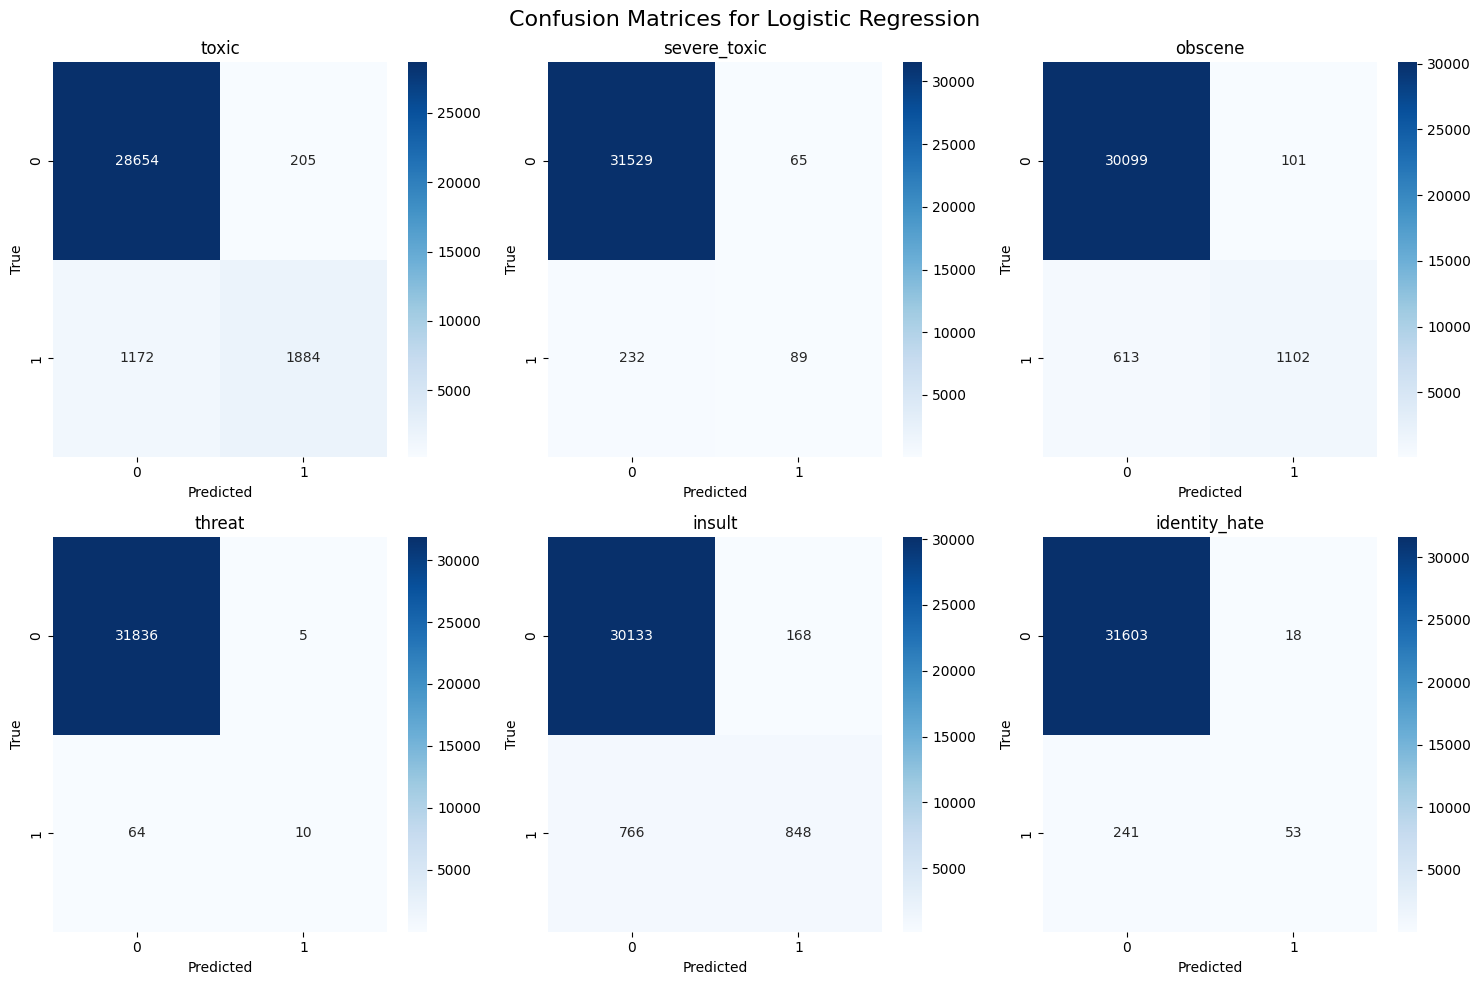

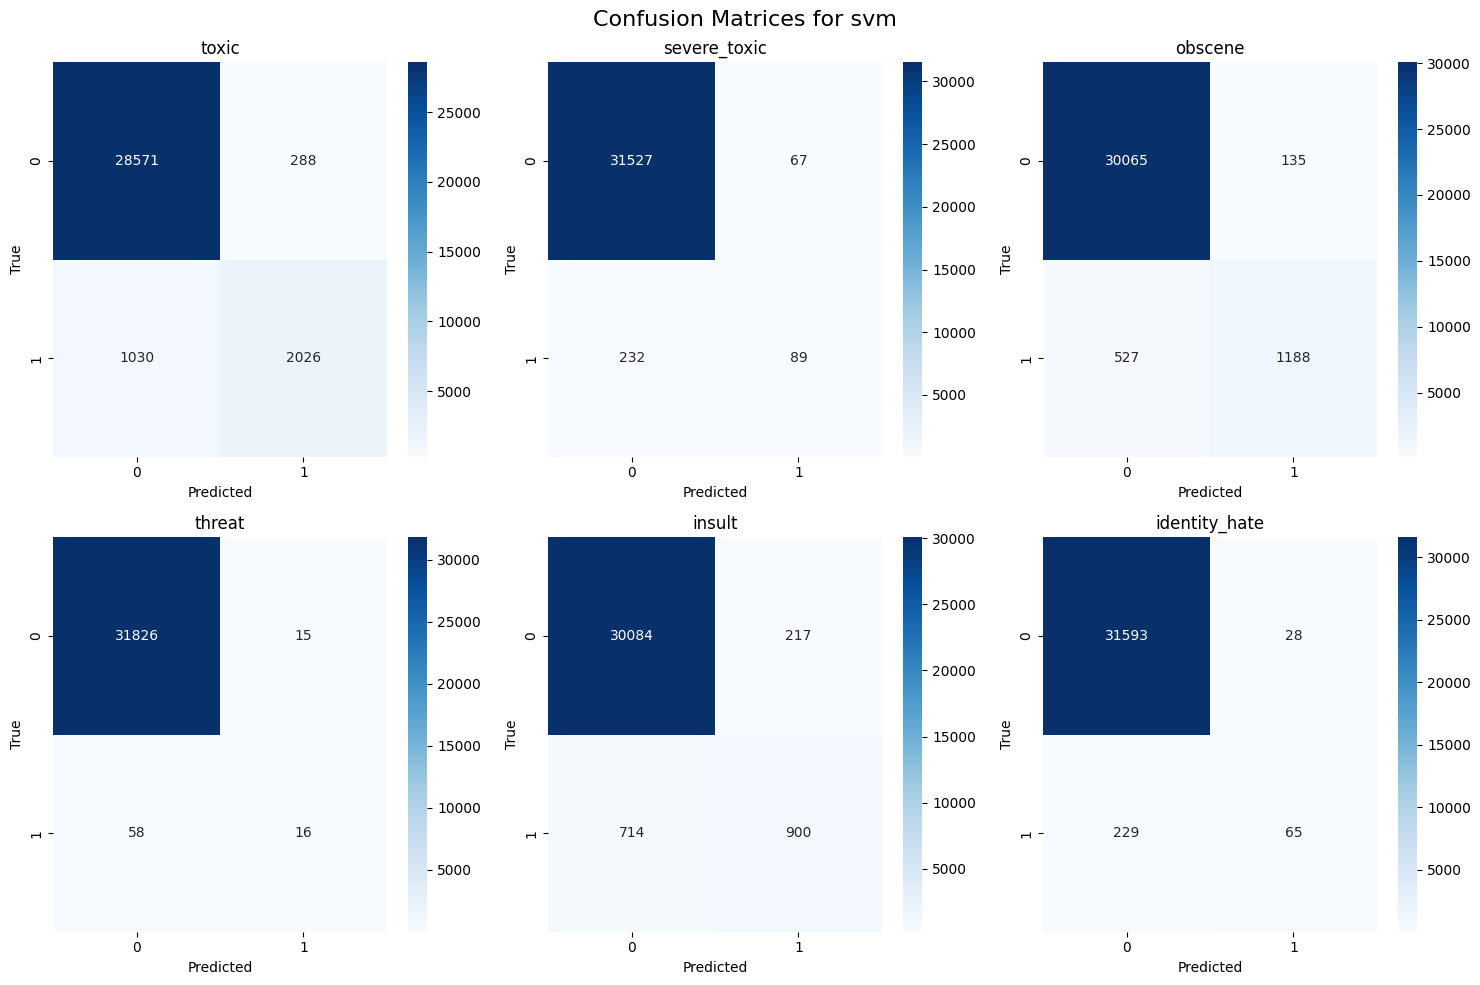

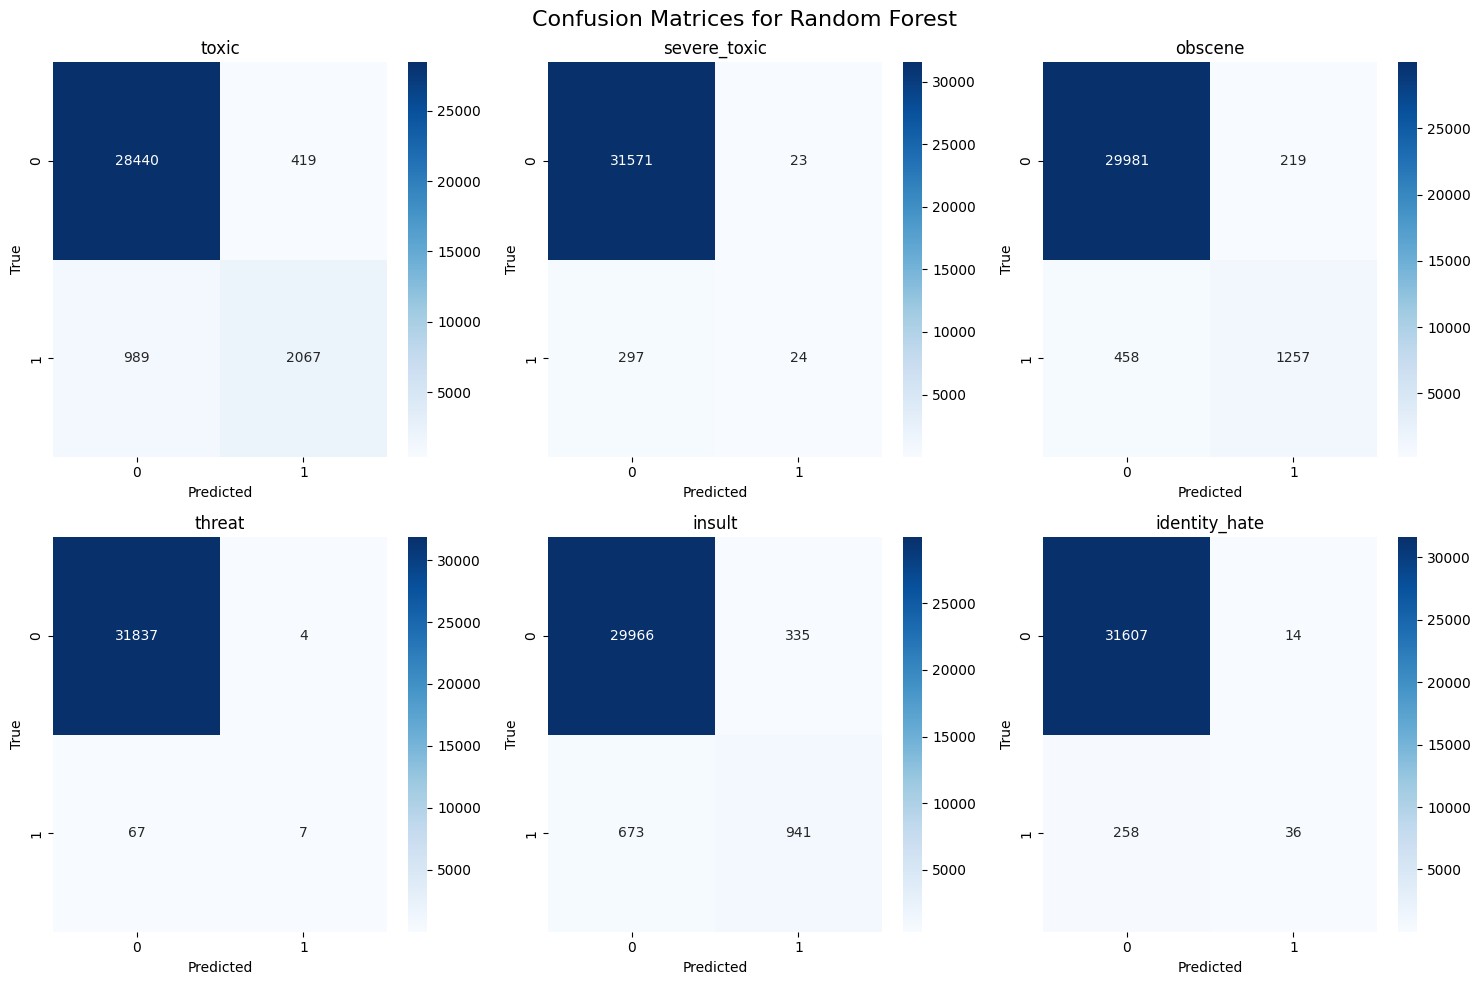

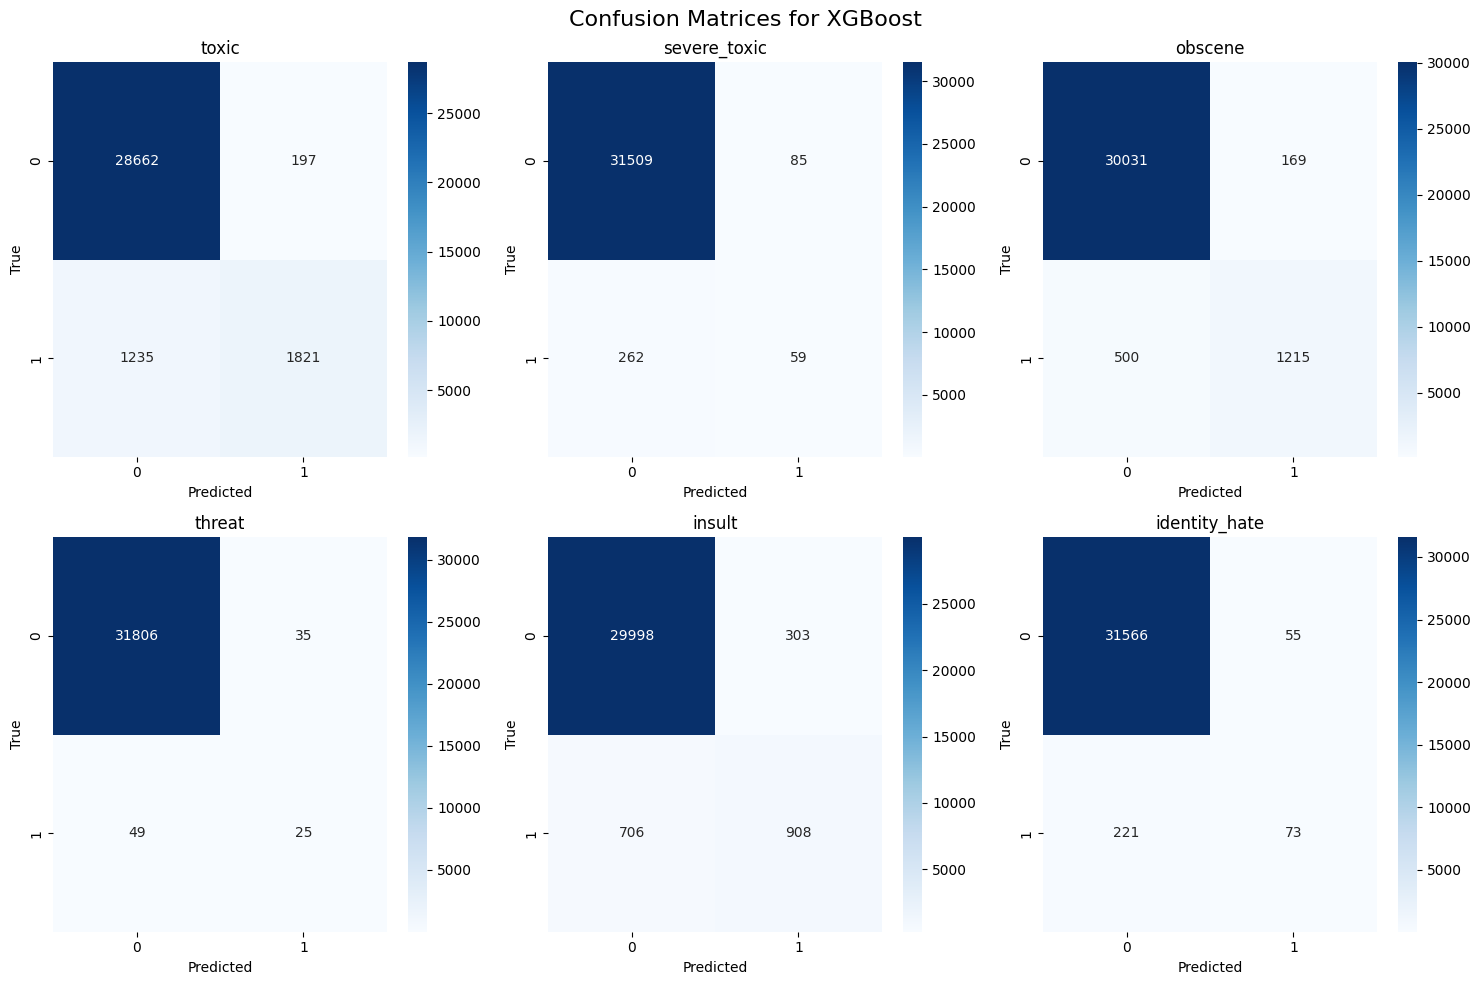

In [67]:
# 🎯 Confusion Matrices
models = {
    "Logistic Regression": log_reg,
    "svm":svm_clf,
    "Random Forest": rf,
    "XGBoost": xgb
}

for name, model in models.items():
    y_pred = model.predict(X_test_tfidf)
    mcm = multilabel_confusion_matrix(y_test, y_pred)
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"Confusion Matrices for {name}", fontsize=16)
    
    for i, label in enumerate(labels):  # labels = list of your 6 categories
        row, col = divmod(i, 3)
        sns.heatmap(mcm[i], annot=True, fmt="d", cmap="Blues", ax=axes[row][col])
        axes[row][col].set_title(label)
        axes[row][col].set_xlabel("Predicted")
        axes[row][col].set_ylabel("True")
    
    plt.tight_layout()
    plt.show()



In [68]:
models = {
    "Logistic Regression": log_reg,
    "Random Forest": rf,
    "XGBoost": xgb
}

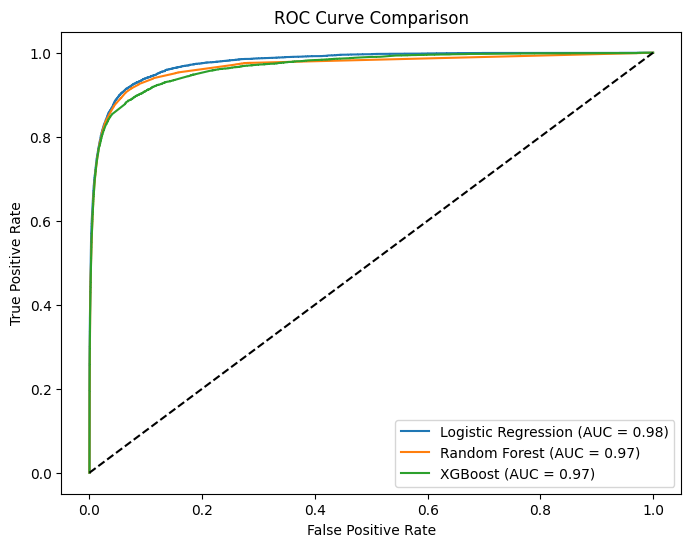

In [69]:
# 🎯 ROC Curves Comparison
plt.figure(figsize=(8,6))

for name, model in models.items():
    y_proba = model.predict_proba(X_test_tfidf)
    y_proba = np.array([p[:,1] for p in y_proba]).T
    
    fpr, tpr, _ = roc_curve(y_test.values.ravel(), y_proba.ravel())
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.show()

In [70]:
import joblib

# Save models
joblib.dump(svm_clf, "svm_model.pkl")
joblib.dump(rf, "random_forest_model.pkl")
joblib.dump(xgb, "xgboost_model.pkl")



print("✅ All models and vectorizer saved successfully!")


✅ All models and vectorizer saved successfully!


In [71]:
import joblib

log_reg = joblib.load("log_reg_model.pkl")
svm = joblib.load("svm_model.pkl")
rf = joblib.load("random_forest_model.pkl")
xgb = joblib.load("xgboost_model.pkl")
tfidf = joblib.load("tfidf_vectorizer.pkl")

print("✅ Models and vectorizer loaded successfully!")


✅ Models and vectorizer loaded successfully!
